In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy
import emcee

from ctisim.image import ImageSimulator, SegmentSimulator
from ctisim.utils import OverscanParameterResults, ITL_AMP_GEOM
from ctisim.core import FloatingOutputAmplifier, LinearTrap, LogisticTrap
from ctisim.fitting import OverscanFitting, SimulatedTrapModel

# ITL Full Deferred Charge Model

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATASEC = '[4:512,1:2000]'                                                      
NAMPS   =                   16                                                  
CHECKSUM= 'QY2RQX1PQX1PQX1P'   / HDU checksum updated 2020-01-29T13:45:00       
DATASUM = '0       '           / data unit checksum updated 2020-01-29T13:45:00  



Text(0.5, 0, 'Signal [e-]')

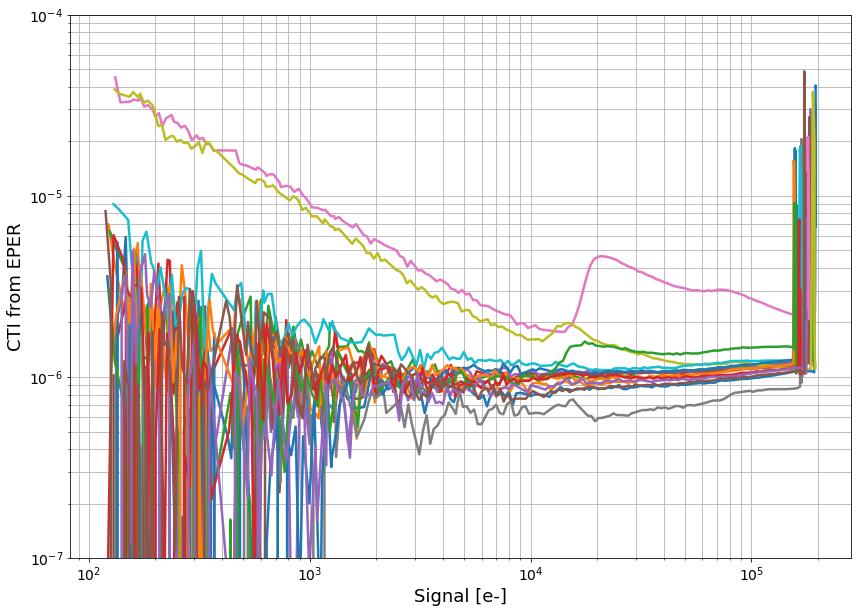

In [3]:
## Overscan results header
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

prihdr = hdul[0].header
print(repr(prihdr), '\n')

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for amp in range(1, 17):
    data = hdul[amp].data
    signal_all = data['FLATFIELD_SIGNAL']
    indices = np.argsort(signal_all)
    signal_data = signal_all[indices]

    last_pix = data['COLUMN_MEAN'][:, 511]
    oscan1 = data['COLUMN_MEAN'][:, 512]
    #oscan2 = data['MEANROW'][:, 513]
    oscan2 = 0
    cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
    ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Floating Output Amplifier Fitting

In [22]:
amp = 9

## Get data for comparison
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

data = hdul[amp].data
signals = data['FLATFIELD_SIGNAL']

last_pix = data['COLUMN_MEAN'][:, 511]
oscan1 = data['COLUMN_MEAN'][:, 512]
oscan2 = data['COLUMN_MEAN'][:, 513]
cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
amp_fit_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_fit_results.fits'
hdul = fits.open(amp_fit_results)

decay_times = hdul[1].data['DECAY_TIME']
drift_scales = hdul[1].data['DRIFT_SIZE']

output_amplifier = FloatingOutputAmplifier(1.0, drift_scales[amp-1]/10000., decay_times[amp-1], noise=0.0, offset=0.0)
print(output_amplifier.scale, output_amplifier.decay_time)

0.00022338507175445556 2.5061266


Text(0.5, 0, 'Signal [e-]')

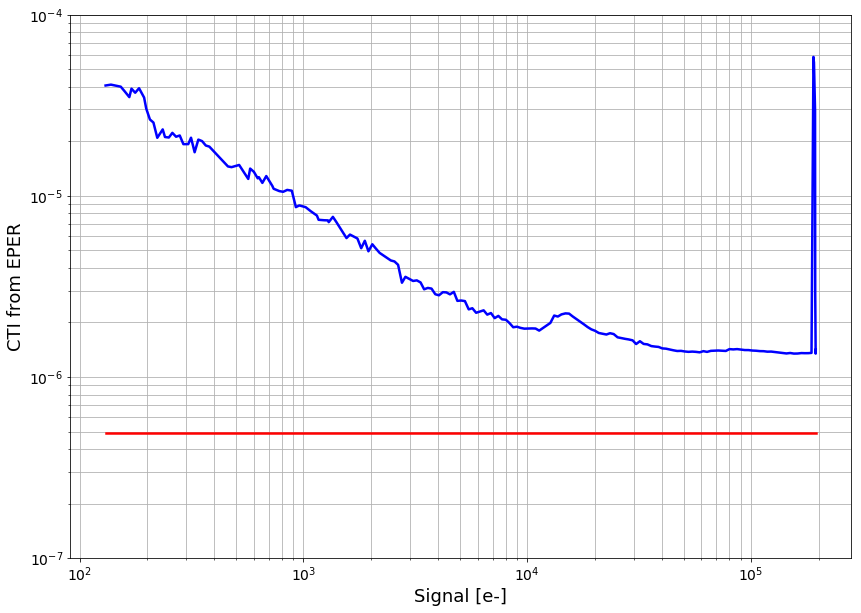

In [23]:
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier)
ramp.ramp_exp(signals)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_model = ((oscan1+oscan2)/(512*last_pix))
    
ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')

    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Low Signal Trap Fitting

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
SENSORID= 'R20_S02 '                                                            
AMP     =                    7                                                  
TYPE    = 'linear  '                                                            
STEPS   =                    8                                                  
WALKERS =                 5000                                                  


Text(0.5, 0, 'Signal [e-]')

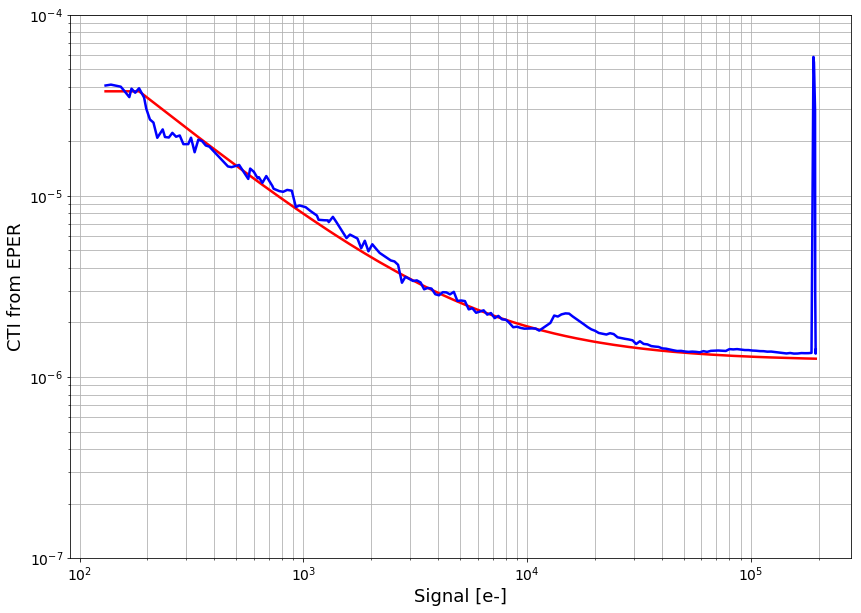

In [24]:
## Low signal trapping
mcmc_results = fits.open('../examples/output/R20_S02_9_trap_mcmc_results.fits')

print(repr(mcmc_results[0].header))

## Trap parameters
amp=9
cti_chain = mcmc_results[1].data
trapsize_chain = mcmc_results[2].data
emission_time_chain = mcmc_results[3].data
scaling_chain = mcmc_results[4].data
cti = 10**np.median(cti_chain[:, 500:])

low_trap = LinearTrap(np.median(trapsize_chain[:, 500:]), np.median(emission_time_chain[:, 500:]), 1,
                      np.median(scaling_chain[:, 500:]))

## Make CTI curve
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, 
                        cti=cti, traps=low_trap)
ramp.ramp_exp(signals)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = segarr[:, 513]
cti_model = ((oscan1+oscan2)/(512*last_pix))

ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

## Mid Signal Trapping

Text(0.5, 0, 'Signal [e-]')

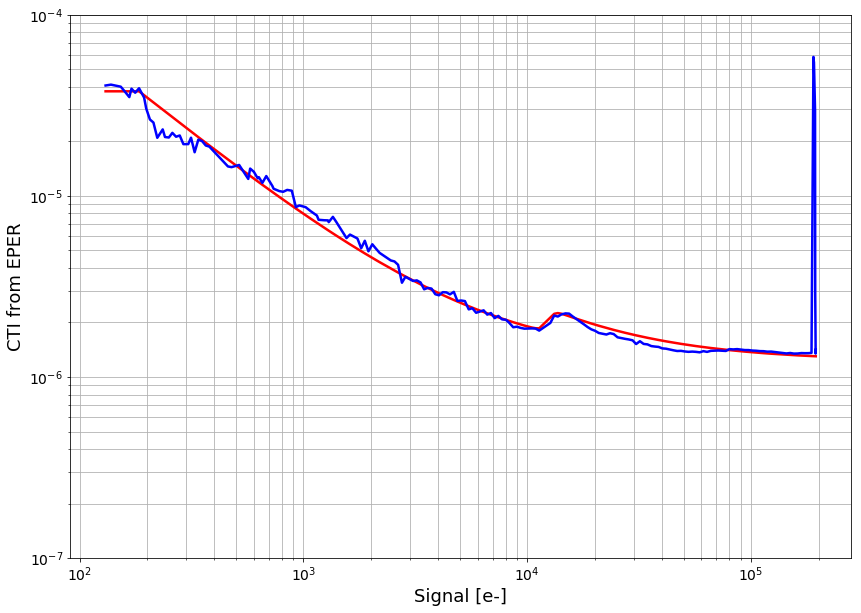

In [25]:
## Tuning by hand
midsignal_trap = LogisticTrap(4, 0.5, 1, 12500., 0.0025)
    
imarr = np.zeros((len(signals), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[low_trap, midsignal_trap])
flat.ramp_exp(signals)

im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

last_pix = im[:, 511]
oscan1 = im[:, 512]
oscan2 = im[:, 513]
cti_model = (oscan1+oscan2)/(512*last_pix)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))


ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [7]:
## Setting up MCMC Chain

ctiexp = np.log10(cti)
params0 = (ctiexp, 4., 0.5, 12500., 0.0025)
constraints = [(ctiexp-0.2, ctiexp+0.2), (0, 10.), (0.01, 1.0), (11000., 15000.), (0.0001, 0.004)]

overscan_fitting = OverscanFitting(params0, constraints, SimulatedTrapModel, start=1, stop=5)

nwalkers=10
scale = (0.02, 0.5, 0.05, 500., 0.001)
pos = overscan_fitting.initialize_walkers(scale, nwalkers)
error = 7.0/np.sqrt(2000.)

In [29]:
new_indices = (signals>10000.)*(signals<20000.)
column_data = data['COLUMN_MEAN'][new_indices, 512:517]
signal_data = signals[new_indices]
print(column_data.shape)
print(signal_data.shape)

(14, 5)
(14,)


In [30]:
args = (signal_data, column_data, error, ITL_AMP_GEOM, LogisticTrap, output_amplifier)
kwargs = {'traps' : low_trap}

sampler =emcee.EnsembleSampler(nwalkers, 5, overscan_fitting.logprobability, args=args, kwargs=kwargs)

In [31]:
sampler.run_mcmc(pos, 200)

(array([[-6.16642031e+00,  3.96835213e+00,  3.45665307e-01,
          1.26733069e+04,  2.80195830e-03],
        [-6.20138134e+00,  4.56974673e+00,  3.48515116e-01,
          1.26805493e+04,  1.89368885e-03],
        [-6.17689938e+00,  4.28098148e+00,  3.31485162e-01,
          1.27496401e+04,  2.19669998e-03],
        [-6.15449313e+00,  3.77037702e+00,  3.29912048e-01,
          1.26513876e+04,  2.31113360e-03],
        [-6.17987689e+00,  4.21473880e+00,  3.45022413e-01,
          1.26324567e+04,  1.75803683e-03],
        [-6.17095091e+00,  4.09018079e+00,  3.71535616e-01,
          1.26506276e+04,  2.45018985e-03],
        [-6.20629978e+00,  4.75782763e+00,  3.13153206e-01,
          1.25842472e+04,  1.78934688e-03],
        [-6.17354769e+00,  4.01642853e+00,  2.65435668e-01,
          1.26696455e+04,  2.13986009e-03],
        [-6.21308165e+00,  4.58182431e+00,  3.18814467e-01,
          1.26514950e+04,  2.44362464e-03],
        [-6.17412381e+00,  4.15986592e+00,  3.52115929e-01,
    

In [32]:
chain = sampler.chain
r = np.mean(chain[:, 20:, :], axis=(0, 1))
print(r)

[-6.15695067e+00  3.95117265e+00  3.49829582e-01  1.26508004e+04
  2.01326520e-03]


Text(0.5, 0, 'Signal [e-]')

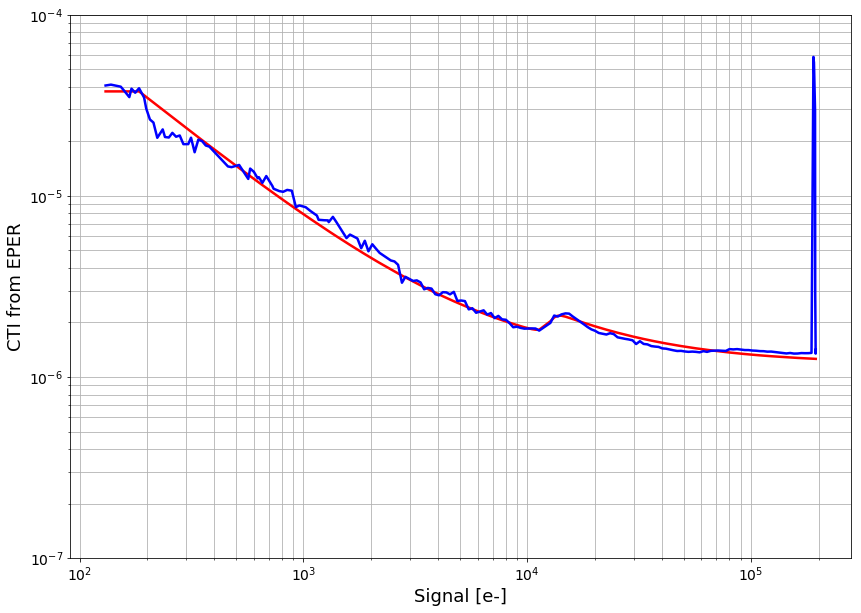

In [34]:
## MCMC Parameters 
cti = 10**r[0]
mid_trap = LogisticTrap(r[1], r[2], 1, r[3], r[4])
    
imarr = np.zeros((len(signals), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[low_trap, mid_trap])
flat.ramp_exp(signals)

im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

last_pix = im[:, 511]
oscan1 = im[:, 512]
oscan2 = im[:, 513]
cti_model = (oscan1+oscan2)/(512*last_pix)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))


ax.plot(signals, cti_model, linewidth=2.5, color='red')
ax.plot(signals, cti_data, linewidth=2.5, color='blue')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [35]:
from ctisim.utils import save_mcmc_results

save_mcmc_results('R20_S02', 9, sampler.chain, 'R20_S02_Amp{0}_midtrap_mcmc.fits'.format(amp), LogisticTrap)